# Support material
#### Direct generation of the quantum circuit for an iterative quantamorphism (qfor-loop) parametric on the number of qubits of the control and comparison with that generated by a unitary in Quippe

In [1]:
# Useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer

backend = BasicAer.get_backend('unitary_simulator')

In [3]:
import sys

In [4]:
from dataclasses import dataclass
from typing import Union, NoReturn

# $qfor f (n,b)$

In [5]:
def what_f(f):
    t = p = l = 0
    if f == 'X':
        t = pi
        p = 0
        l = pi
    elif f == 'Y':
        t = pi
        p = pi/2
        l = pi/2
    elif f == 'Z':
        t = 0
        p = 0
        l = pi
    elif f == 'H':
        t = pi/2
        p = 0
        l = pi
    elif f == 'S':
        t = 0
        p = 0
        l = pi/2
    elif f == 'Sdg':
        t = 0
        p = 0
        l = -pi/2
    elif f == 'T':
        t = 0
        p = 0
        l = pi/4
    elif f == 'Tdg':
        t = 0
        p = 0
        l = -pi/4
    # (theta, phi, lambda)
    return (t, p, l)   

# test
what_f('Z')

(0, 0, 3.141592653589793)

In [6]:
def assert_never(x: NoReturn) -> NoReturn:
    raise AssertionError("Unhandled type: {}".format(type(x).__name__))

@dataclass(frozen=True)
class Q:
    value: int

@dataclass(frozen=True)
class T:
    pass

@dataclass(frozen=True)
class F:
    pass

@dataclass(frozen=True)
class And:
    left: 'BExp'
    right: 'BExp'

@dataclass(frozen=True)
class Or:
    left: 'BExp'
    right: 'BExp'

BExp = Union[Q, T, F, And, Or]

def showBExp(r: BExp) -> str:
    if isinstance(r, T):
        return "1"
    elif isinstance(r, F):
        return "0"
    elif isinstance(r, Q):
        return ("q" + str(r.value))
    elif isinstance(r, And):
        return (showBExp(r.left) + "*" + showBExp(r.right))
    elif isinstance(r, Or):
        return ("(" + showBExp(r.left) + "+" + showBExp(r.right) + ")")
    else:
        assert_never(r)

def andBExp(a: BExp, b : BExp) -> BExp:
    if isinstance(b, T):
        return a
    elif isinstance(a, T):
        return b
    else:
        return And(a, b)

def orBExp(a: BExp, b : BExp) -> BExp:
    if isinstance(b, T):
        return T()
    elif isinstance(a, T):
        return T()
    else:
        return Or(a, b)

def f(n):
    if n == 0:
        return [Q(0), T()]
    else:
        x = f(n - 1)
        y = f(n - 1) # useless, x is the same value
        return ([andBExp(Q(n), e) for e in x] + [orBExp(Q(n), e) for e in y])

# assumes n >= 0
def main0(n : int):
    pred = n  - 1

    l = f(pred)
    l.reverse()

    zero_to_len = list(range(0, len(l)))
    zipped = list(zip(zero_to_len, l))
    zipped.reverse()

    toPrint = ""
    l =[]
    for (n, s) in zipped:
        #toPrint += ("\n(>= " + str(n) + ") = " + showBExp(s))
        l.append(showBExp(s))
    return l
    #print(toPrint + "\n")

In [7]:
def what_n(n):
    l = main0(n)
    cl=[]
    for x in l:
        x = "".join([char for char in x if char != ")" and char != "("])
        cl.append(x) 
    rl =[x[::-1] for x in cl]
    return rl[::-1]

#test
print(what_n(3))

['1', '0q+1q+2q', '1q+2q', '0q*1q+2q', '2q', '0q+1q*2q', '1q*2q', '0q*1q*2q']


In [8]:
def qfor_init(f,n):
    (t,p,l) = what_f(f)
    list_controls = what_n(n)
    print('OPENQASM 2.0;\ninclude "qelib1.inc";')

    if n <= 1:
        # the number of qubits
        qn=n
        print('qreg q[%d];'%(n+1))
        print('\n')
    else: 
        # the number of qubits
        qn = n + n
        print('qreg q[%d];'%qn)
    qfor(f,n,list_controls)

In [9]:
#writting pseudo qasm
def qfor(f, qn, lnn, d=0):
    # f   - function <str>
    # qn  - corresponds to the number of controls <int>
    # lnn - type of controls <lst>
    # d   - decomposition level <int>

    # defining the funtion f 
    (theta,phi,lambdaa) = what_f(f)
    # target
    tg = 0
    if lnn == []:
        return
    # g - gate we are implementing
    g=lnn.pop(0)
    # lg - instruction size
    lg = len(g)        
    try:
        aj = [d*3+2 for d in range(qn-1)]
        jj = aj + aj[::-1]
        j = jj[d]
        if g[j]=='*':
            # no need for decompostion
            if lg == 5 and d==0:
                print('ccx q[%d], q[%d], q[%d];'%(qn,(qn-1),(qn+1)))
                print('cu3 (%0.3f, %0.3f, %0.3f) q[%d], q[%d];'%(theta,phi,lambdaa,(qn+1),tg))
                print('ccx q[%d], q[%d], q[%d];'%(qn,(qn-1),(qn+1)))
                d=0
            # first gate in the decomposition 
            elif d==0:
                print('ccx q[%d], q[%d], q[%d];'%((tg+1),(tg+2),(qn+1)))
                d+=1
                lnn=[g,*lnn]
            #last instruction
            elif d==qn+(qn-3):
                print('ccx q[%d], q[%d], q[%d];'%((tg+1),(tg+2),(qn+1)))
                d=0
            #reverse
            elif d>qn-2:
                #gates in decomposition
                print('ccx q[%d], q[%d], q[%d];'%((qn+(qn-1)-d),(qn*2-d+(qn-3)),(qn*2-d+(qn-2))))
                d+=1
                lnn=[g,*lnn]
            #other gates in decomposition
            else:
                #gates in decomposition
                print('ccx q[%d], q[%d], q[%d];'%((d+2),(qn+d),(qn+d+1)))
                #last gate in decomposition
                if d==qn-2:
                    print('cu3(%0.3f, %0.3f, %0.3f) q[%d], q[%d];'%(theta,phi,lambdaa,(qn*2-1),tg))
                d+=1
                lnn=[g,*lnn]
            qfor(f,qn,lnn,d)
        elif g[j]=='+':
            # no need for decomposition
            if lg == 5 and d==0:
                print('x q[%d];'%(qn-1))
                print('x q[%d];'%qn)
                print('ccx q[%d], q[%d], q[%d];'%(qn,(qn-1),(qn+1)))
                print('x q[%d];'%(qn+1))
                print('cu3 (%0.3f, %0.3f, %0.3f) q[%d], q[%d];'%(theta,phi,lambdaa,(qn+1),tg))
                print('x q[%d];'%(qn+1))
                print('ccx q[%d], q[%d], q[%d];'%(qn,(qn-1),(qn+1)))
                print('x q[%d];'%(qn-1))
                print('x q[%d];'%qn)
                d=0
            # first gate in the decomposition 
            elif d==0:
                print('x q[%d];'%(tg+1))
                print('x q[%d];'%(tg+2))
                print('ccx q[%d], q[%d], q[%d];'%((tg+1),(tg+2),(qn+1)))
                print('x q[%d];'%(qn+1))
                d+=1
                lnn=[g,*lnn]
            #last instruction
            elif d==qn+(qn-3):
                print('x q[%d];'%(qn+1))
                print('ccx q[%d], q[%d], q[%d];'%((tg+1),(tg+2),(qn+1)))
                print('x q[%d];'%(tg+1))
                print('x q[%d];'%(tg+2))
                d=0
            #reverse
            elif d>qn-2:
                #gates in decomposition
                print('x q[%d];'%(qn*2+1-d))
                print('ccx q[%d], q[%d], q[%d];'%((qn+(qn-1)-d),(qn*2-d+(qn-3)),(qn*2-d+(qn-2))))
                print('x q[%d];'%(qn+2-d))
                print('x q[%d];'%(qn*2-d))
                d+=1
                lnn=[g,*lnn]
            #other gates in decomposition
            else:
                #gates in decomposition
                print('x q[%d];'%(d+2))
                print('x q[%d];'%(qn+d))
                print('ccx q[%d], q[%d], q[%d];'%((d+2),(qn+d),(qn+d+1)))
                print('x q[%d];'%(qn+d+1))
                #last gate in decomposition
                if d==qn-2:
                    print('cu3 (%0.3f, %0.3f, %0.3f) q[%d], q[%d];'%(theta,phi,lambdaa,(qn*2-1),tg))
                d+=1
                lnn=[g,*lnn]
            qfor(f,qn,lnn,d)    
    except IndexError:
        # the initial case qn = 0 ( >= 0 )
        if g=='1':
            print('id q[%d];'%tg)
            #print('u3(%0.3f, %0.3f, %0.3f) q[%d];'%(theta,phi,lambdaa,tg))
        # the target only has one control 
        else:
            # control target
            print('cu3 (%0.3f, %0.3f, %0.3f) q[%d], q[%d];'%(theta,phi,lambdaa,qn,tg))
        qfor(f,qn,lnn) 

In [10]:
qfor_init('S', 3)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[6];
id q[0];
x q[1];
x q[2];
ccx q[1], q[2], q[4];
x q[4];
x q[3];
x q[4];
ccx q[3], q[4], q[5];
x q[5];
cu3 (0.000, 0.000, 1.571) q[5], q[0];
x q[5];
ccx q[3], q[4], q[5];
x q[3];
x q[4];
x q[4];
ccx q[1], q[2], q[4];
x q[1];
x q[2];
x q[2];
x q[3];
ccx q[3], q[2], q[4];
x q[4];
cu3 (0.000, 0.000, 1.571) q[4], q[0];
x q[4];
ccx q[3], q[2], q[4];
x q[2];
x q[3];
ccx q[1], q[2], q[4];
x q[3];
x q[4];
ccx q[3], q[4], q[5];
x q[5];
cu3 (0.000, 0.000, 1.571) q[5], q[0];
x q[5];
ccx q[3], q[4], q[5];
x q[3];
x q[4];
ccx q[1], q[2], q[4];
cu3 (0.000, 0.000, 1.571) q[3], q[0];
x q[1];
x q[2];
ccx q[1], q[2], q[4];
x q[4];
ccx q[3], q[4], q[5];
cu3(0.000, 0.000, 1.571) q[5], q[0];
ccx q[3], q[4], q[5];
x q[4];
ccx q[1], q[2], q[4];
x q[1];
x q[2];
ccx q[3], q[2], q[4];
cu3 (0.000, 0.000, 1.571) q[4], q[0];
ccx q[3], q[2], q[4];
ccx q[1], q[2], q[4];
ccx q[3], q[4], q[5];
cu3(0.000, 0.000, 1.571) q[5], q[0];
ccx q[3], q[4], q[5];
ccx q[1], q[2], q[4];


In [11]:
%%capture cap --no-stderr

qfor_init('S', 3)

In [12]:
with open('output.qasm', 'w') as f:
    f.write(cap.stdout)

In [13]:
qc=QuantumCircuit.from_qasm_file('output.qasm')

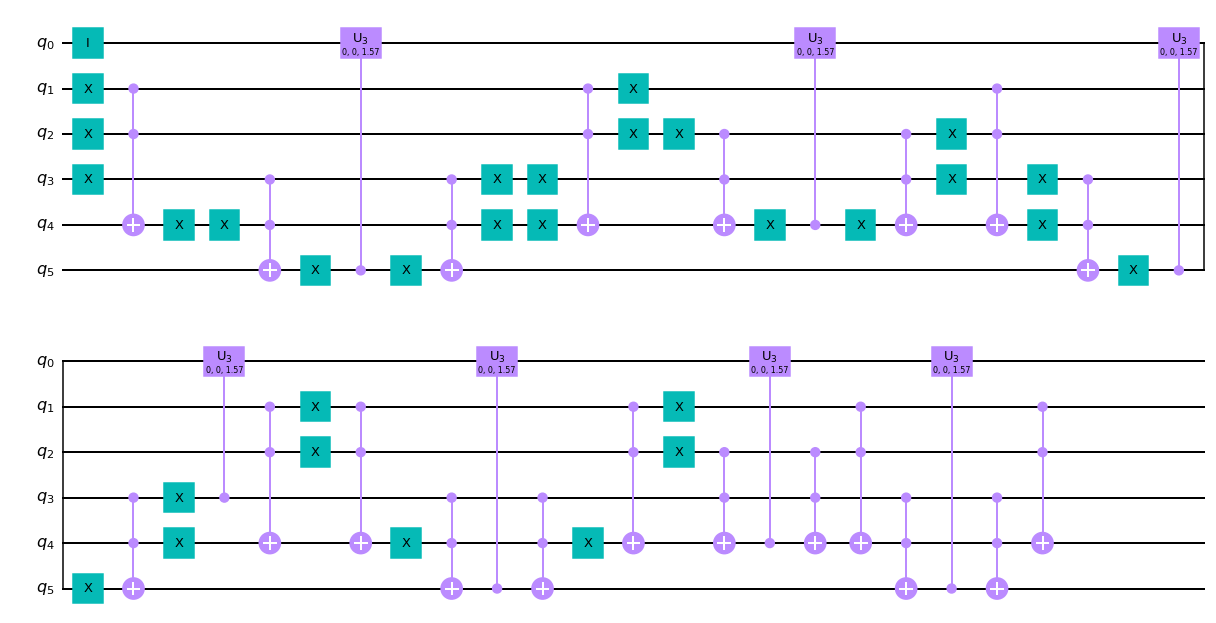

In [14]:
qc.draw(output='mpl')

In [15]:
job_matrix = execute(qc, backend)
matrix_res = job_matrix.result()
matrix = matrix_res.get_unitary(qc, decimals=3)

In [16]:
np.set_printoptions(threshold=sys.maxsize)

In [17]:
count = 0
final = [[]]
for i in matrix:
    if count<16:
        count2 = 0
        for j in i:
            if count2>=16:
                break
            else:
                j = round(j.real, 2) + round(j.imag, 2) * 1j
                if j==0j:
                    j=0
                elif j==(1+0j):
                    j=1
                elif j==(-1+0j):
                    j=-1
                final[count].append(j)
            count2+=1
        if count<15:
            final.append([])
    else:
        break
    count+=1

In [18]:
final

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1j, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, -1j, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1j, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1j]]

### Comparing with the previous toolchain

In [19]:
import pyzx as zx

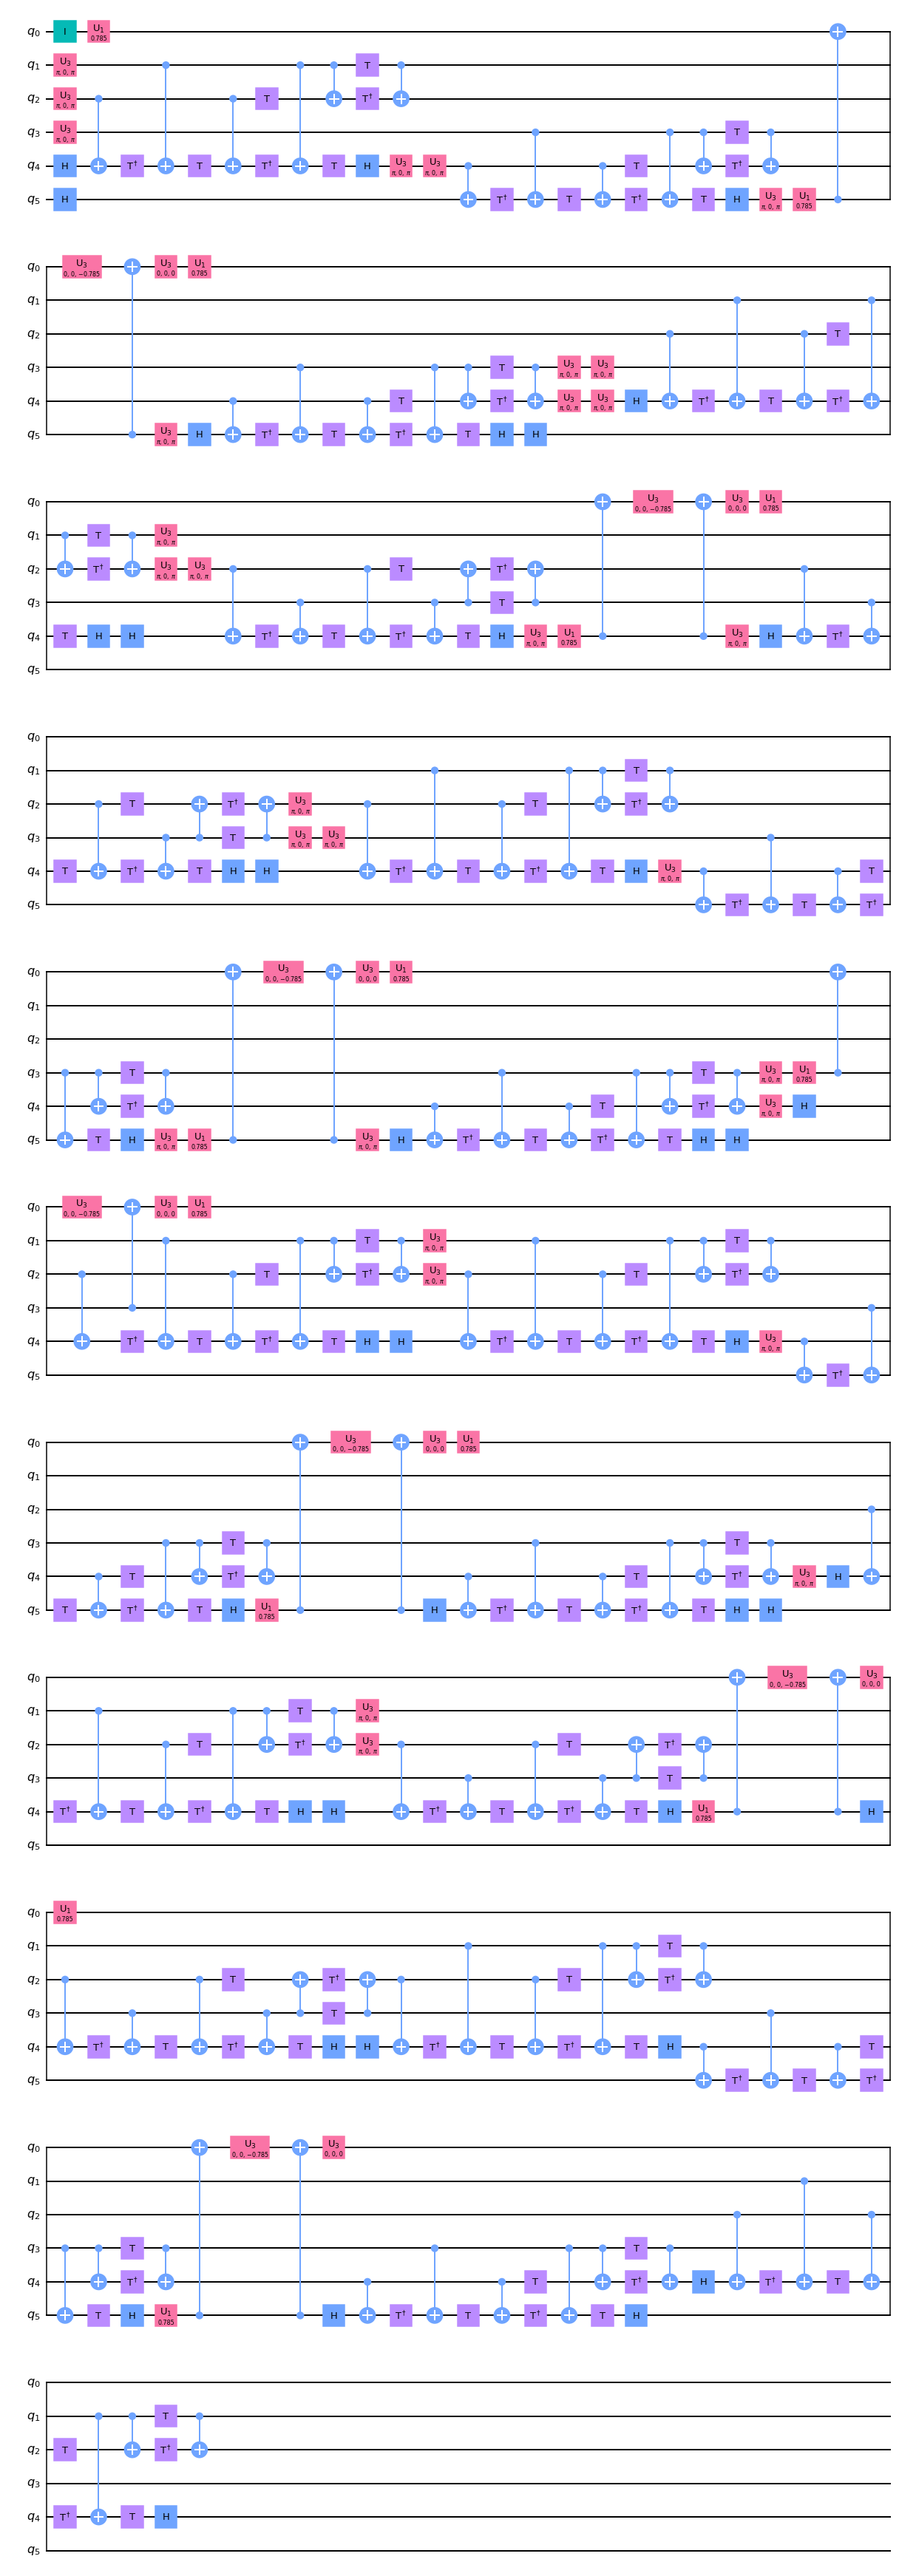

In [39]:
qc_basis = qc.decompose()
qc_basis.draw(output='mpl')

In [41]:
from qiskit import transpile
from qiskit.visualization import plot_circuit_layout
from qiskit.test.mock import FakeMelbourne
backend = FakeMelbourne()

In [57]:
strqasm = QuantumCircuit.qasm(qc_basis)

In [58]:
%%capture cap --no-stderr
print(strqasm)

In [59]:
with open('strqasm.qasm', 'w') as f:
    f.write(cap.stdout)

In [95]:
my_qc = zx.Circuit.load("strqasm.qasm")

In [96]:
print(my_qc.gates)

[ZPhase(0,phase=20854934/83408921), ZPhase(1,phase=1), XPhase(1,phase=1/2), ZPhase(1,phase=0), XPhase(1,phase=1/2), ZPhase(1,phase=1), ZPhase(2,phase=1), XPhase(2,phase=1/2), ZPhase(2,phase=0), XPhase(2,phase=1/2), ZPhase(2,phase=1), ZPhase(3,phase=1), XPhase(3,phase=1/2), ZPhase(3,phase=0), XPhase(3,phase=1/2), ZPhase(3,phase=1), HAD(4), CNOT(2,4), T*(4), CNOT(1,4), T(4), CNOT(2,4), T(2), T*(4), CNOT(1,4), CNOT(1,2), T(1), T*(2), CNOT(1,2), T(4), HAD(4), ZPhase(4,phase=1), XPhase(4,phase=1/2), ZPhase(4,phase=0), XPhase(4,phase=1/2), ZPhase(4,phase=1), ZPhase(4,phase=1), XPhase(4,phase=1/2), ZPhase(4,phase=0), XPhase(4,phase=1/2), ZPhase(4,phase=1), HAD(5), CNOT(4,5), T*(5), CNOT(3,5), T(5), CNOT(4,5), T(4), T*(5), CNOT(3,5), CNOT(3,4), T(3), T*(4), CNOT(3,4), T(5), HAD(5), ZPhase(5,phase=1), XPhase(5,phase=1/2), ZPhase(5,phase=0), XPhase(5,phase=1/2), ZPhase(5,phase=1), ZPhase(5,phase=20854934/83408921), CNOT(5,0), ZPhase(0,phase=-20854934/83408921), XPhase(0,phase=1/2), ZPhase(0,phas

In [97]:
c = c.to_basic_gates()
print(c.gates)

[CNOT(3,4), CNOT(4,3), CNOT(3,4), CNOT(1,5), CNOT(5,1), CNOT(1,5), CNOT(0,4), CNOT(4,0), CNOT(0,4), HAD(5), HAD(4), HAD(2), HAD(0), ZPhase(2,phase=1), HAD(2), CZ(2,3), HAD(3), CZ(3,5), ZPhase(5,phase=1), HAD(5), CZ(3,5), ZPhase(3,phase=1/4), HAD(3), CZ(3,5), ZPhase(5,phase=3/4), HAD(5), CZ(2,5), HAD(5), ZPhase(5,phase=7/4), HAD(5), CNOT(5,3), HAD(5), ZPhase(5,phase=1/4), HAD(5), CZ(1,5), HAD(1), CZ(0,1), ZPhase(0,phase=1), HAD(0), CZ(0,1), ZPhase(1,phase=5/4), HAD(1), CZ(0,1), ZPhase(0,phase=7/4), HAD(0), CZ(0,5), ZPhase(5,phase=1/4), HAD(5), CNOT(5,1), HAD(0), ZPhase(0,phase=7/4), HAD(0), CNOT(0,1), HAD(5), ZPhase(5,phase=7/4), HAD(5), CNOT(5,1), HAD(0), HAD(4), CZ(0,4), ZPhase(0,phase=5/4), HAD(0), CZ(0,4), ZPhase(4,phase=20854934/83408921), HAD(4), CZ(0,4), ZPhase(0,phase=41699053/166817842), HAD(5), HAD(0), HAD(4), CZ(4,5), CZ(0,4), ZPhase(4,phase=291936631/166817842), HAD(4), ZPhase(4,phase=3/4), HAD(4), CNOT(4,1), HAD(4), ZPhase(4,phase=1/4), HAD(4), CZ(4,5), ZPhase(5,phase=5/4),

In [98]:
print(c.stats())

Circuit  on 6 qubits with 594 gates.
        141 is the T-count
        453 Cliffords among which 
        169 2-qubit gates (83 CNOT, 86 other) and
        270 Hadamard gates.


In [100]:
g = c.to_graph()
print(g)

Graph(775 vertices, 938 edges)


In [101]:
zx.simplify.full_reduce(g)
print(g)

Graph(116 vertices, 324 edges)


In [102]:
c2 = zx.extract_circuit(g).to_basic_gates()
print(c2.stats())

Circuit  on 6 qubits with 305 gates.
        59 is the T-count
        246 Cliffords among which 
        138 2-qubit gates (91 CNOT, 47 other) and
        106 Hadamard gates.


In [106]:
%%capture cap --no-stderr
print(c2.to_qasm())

In [107]:
with open('final1.qasm', 'w') as f:
    f.write(cap.stdout)

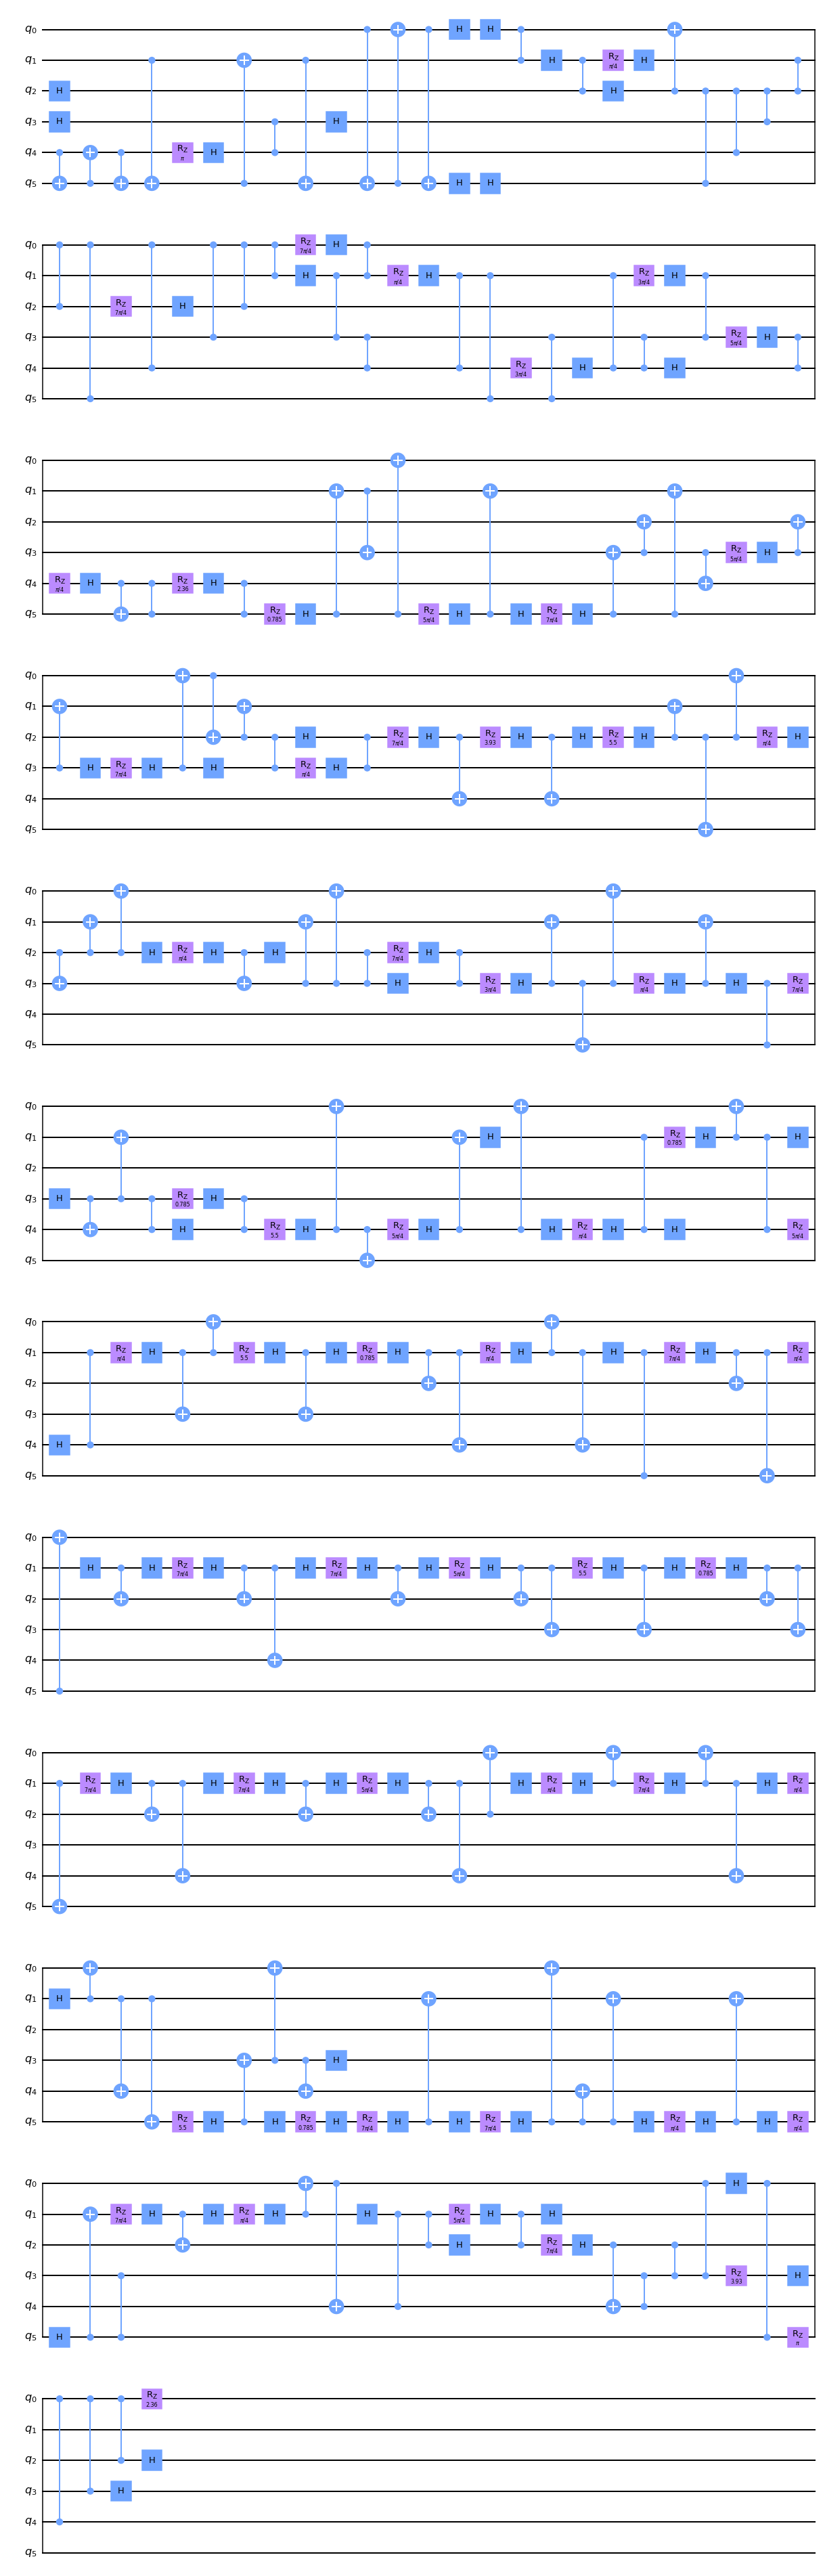

In [139]:
qcfinal=QuantumCircuit.from_qasm_file('final1.qasm')

qcfinal.draw(output='mpl')

In [120]:
my_qc2 = zx.Circuit.from_quipper_file("quipper.txt")

In [121]:
print(my_qc2.gates)

[HAD(0), HAD(1), HAD(2), HAD(4), CNOT(4,0), CNOT(0,1), T(0), T*(1), CNOT(4,0), CNOT(0,1), T*(4), T(1), CNOT(4,1), HAD(4), HAD(5), CNOT(5,2), CNOT(2,4), T(2), T*(4), CNOT(5,2), CNOT(2,4), T*(5), T(4), CNOT(5,4), HAD(5), T*(3), T*(5), CNOT(3,5), T(5), CNOT(3,5), HAD(5), CNOT(5,4), T*(4), T(5), CNOT(2,4), CNOT(5,2), T(4), T*(2), CNOT(2,4), CNOT(5,2), HAD(5), HAD(4), CNOT(4,1), T*(1), T(4), CNOT(0,1), CNOT(4,0), T(1), T*(0), CNOT(0,1), CNOT(4,0), HAD(4), HAD(4), CNOT(4,0), CNOT(0,1), T(0), T*(1), CNOT(4,0), CNOT(0,1), T*(4), T(1), CNOT(4,1), HAD(4), HAD(5), CNOT(5,2), CNOT(2,4), T*(2), T(4), CNOT(5,2), CNOT(2,4), T*(5), T(4), CNOT(5,4), HAD(5), T*(3), T*(5), CNOT(3,5), T(5), CNOT(3,5), HAD(5), CNOT(5,4), T*(4), T(5), CNOT(2,4), CNOT(5,2), T*(4), T(2), CNOT(2,4), CNOT(5,2), HAD(5), HAD(4), CNOT(4,1), T*(1), T(4), CNOT(0,1), CNOT(4,0), T(1), T*(0), CNOT(0,1), CNOT(4,0), HAD(4), HAD(4), CNOT(4,0), CNOT(0,1), T(0), T(1), CNOT(4,0), CNOT(0,1), T*(4), T*(1), CNOT(4,1), HAD(4), HAD(5), CNOT(5,2),

In [122]:
c2 = c2.to_basic_gates()
print(c2.gates)

[CNOT(4,5), CNOT(5,4), CNOT(4,5), CNOT(1,5), CNOT(5,1), CNOT(1,5), CNOT(0,5), CNOT(5,0), CNOT(0,5), HAD(5), HAD(3), HAD(2), HAD(0), HAD(0), CZ(0,1), HAD(1), CZ(1,2), HAD(2), CNOT(2,0), ZPhase(4,phase=1), HAD(4), CZ(3,4), ZPhase(1,phase=1/4), HAD(1), HAD(3), HAD(5), CZ(2,5), CZ(2,4), CZ(2,3), CZ(1,2), CZ(0,2), ZPhase(2,phase=7/4), HAD(2), CZ(0,5), CZ(0,4), CZ(0,3), CZ(0,2), CZ(0,1), ZPhase(0,phase=7/4), HAD(0), HAD(1), CZ(1,3), CZ(0,1), ZPhase(1,phase=1/4), HAD(1), CZ(3,4), CZ(1,4), ZPhase(4,phase=3/4), HAD(4), CZ(1,5), CZ(1,4), ZPhase(1,phase=3/4), HAD(1), CZ(3,5), CZ(3,4), CZ(1,3), ZPhase(3,phase=5/4), HAD(3), HAD(4), CZ(3,4), ZPhase(4,phase=1/4), HAD(4), CNOT(4,5), CZ(4,5), ZPhase(4,phase=125118789/166817842), HAD(4), CZ(4,5), ZPhase(5,phase=41699053/166817842), HAD(5), CNOT(5,1), CNOT(1,3), CNOT(5,0), ZPhase(5,phase=5/4), HAD(5), CNOT(5,1), HAD(5), ZPhase(5,phase=7/4), HAD(5), CNOT(5,3), CNOT(5,1), CNOT(3,2), CNOT(3,4), ZPhase(3,phase=5/4), HAD(3), CNOT(3,2), CNOT(3,1), HAD(3), ZPha

In [123]:
print(c2.stats())

Circuit  on 6 qubits with 305 gates.
        59 is the T-count
        246 Cliffords among which 
        138 2-qubit gates (91 CNOT, 47 other) and
        106 Hadamard gates.


In [124]:
g2 = c2.to_graph()
print(g2)

Graph(455 vertices, 587 edges)


In [125]:
zx.simplify.full_reduce(g2)
print(g2)

Graph(115 vertices, 305 edges)


In [126]:
c22 = zx.extract_circuit(g2).to_basic_gates()
print(c22.stats())

Circuit  on 6 qubits with 293 gates.
        59 is the T-count
        234 Cliffords among which 
        126 2-qubit gates (86 CNOT, 40 other) and
        106 Hadamard gates.


In [127]:
%%capture cap --no-stderr
print(c22.to_qasm())

In [128]:
with open('final2.qasm', 'w') as f:
    f.write(cap.stdout)

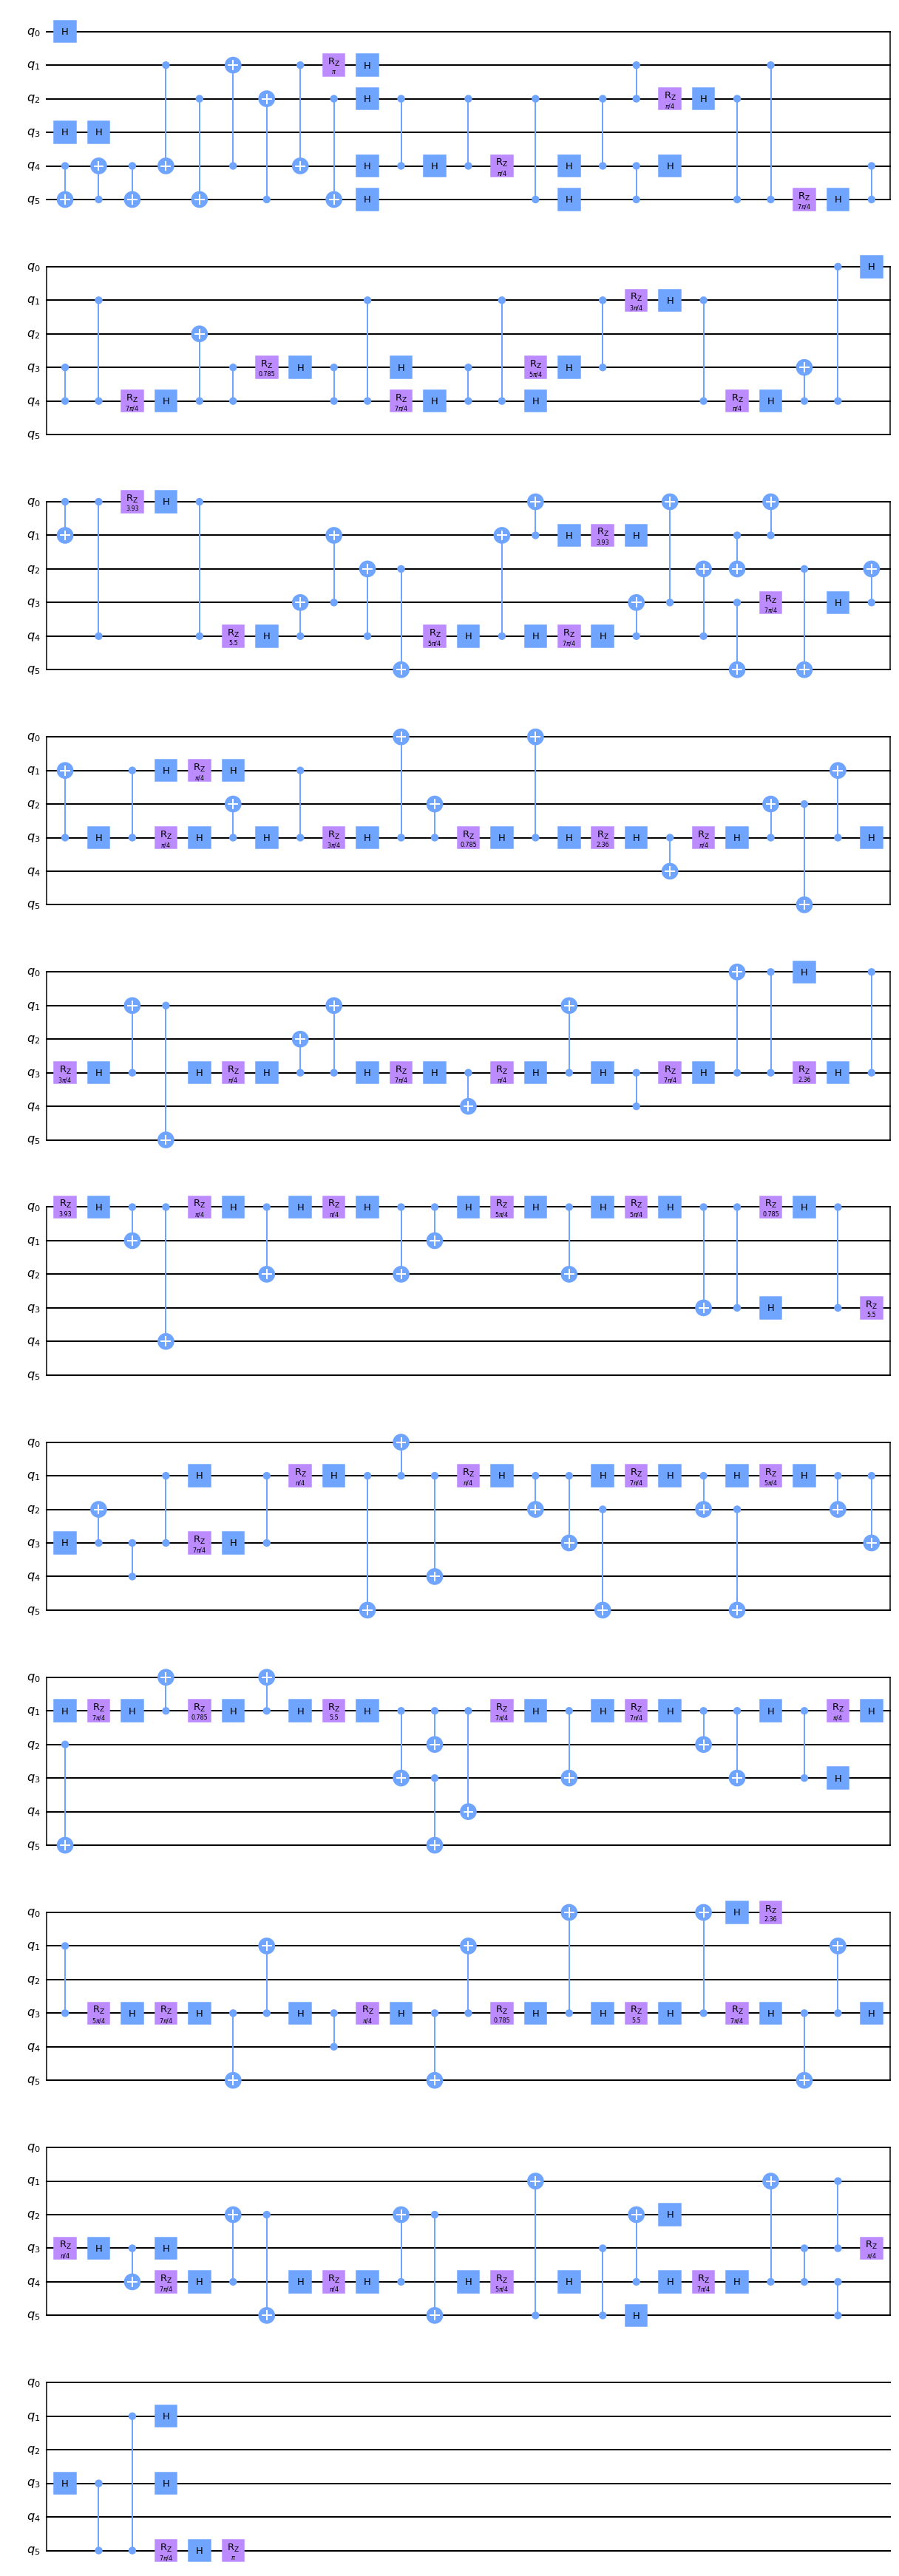

In [131]:
qcfinal2=QuantumCircuit.from_qasm_file('final2.qasm')

qcfinal2.draw(output='mpl')

In [141]:
qcfinal.depth()

262

In [140]:
qcfinal2.depth()

241

In [142]:
qcfinal.width()

6

In [143]:
qcfinal2.width()

6

In [144]:
qcfinal.count_ops()

OrderedDict([('h', 106), ('cx', 91), ('rz', 61), ('cz', 47)])

In [145]:
qcfinal2.count_ops()

OrderedDict([('h', 106), ('cx', 86), ('rz', 61), ('cz', 40)])

### Conclusion

The original experiments employ a toolchain that always resorts to the semantics of the quantamorphism (unitary matrix) to compile the final circuit, via Quipper. This step in the toolchain cripples the prospect of building a scalable compilation scheme.

The alternative (direct) compilation scheme aims to eradicate the unitary matrix from the compilation process.

It turns out that the two circuits end up being incredibly similar. However, the original toolchain returns one with slightly smaller depth, thanks to from simplifications made by Quipper's exact_synthesis function. In the direct approach optimization was not a priority, and the pyzx compiler was not enough to mitigate the consequences of this decision.

Despite the clear room for progress, the experiment shows how to perform direct compilation of a quantum for-loop with a shorter toolchain dispensing with the explicit construction of the unitary matrix.